In [6]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon, box
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="poster", style="white")

from sklearn.metrics import recall_score, precision_score#

In [7]:
df = gpd.read_file("../results/results/test_results_clean.geojson")

In [8]:
df

,polyID,confidence,geometry
0,0,0.141959,"POLYGON ((504157.090 4346532.918, 504157.090 4..."
1,1,0.111056,"POLYGON ((502936.377 4348615.003, 502936.377 4..."
2,2,0.149852,"POLYGON ((503238.981 4349085.336, 503238.981 4..."
3,3,0.334212,"POLYGON ((505096.351 4349217.633, 505096.351 4..."
4,4,0.122452,"POLYGON ((503925.778 4349317.535, 503925.778 4..."
...,...,...,...
733,733,0.264853,"POLYGON ((512533.137 4353341.981, 512533.137 4..."
734,734,0.246031,"POLYGON ((504370.950 4353352.838, 504370.950 4..."
735,735,0.149733,"POLYGON ((498799.791 4352767.206, 498799.791 4..."
736,736,0.130422,"POLYGON ((500263.537 4352769.426, 500263.537 4..."


In [9]:
truth = gpd.read_file("../data/test_bbox_rev.shp")
truth.shape

(589, 29)

In [10]:
overlaps = gpd.sjoin(df, truth)

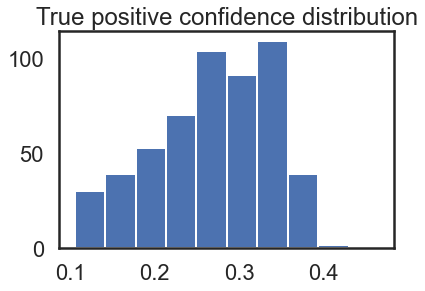

In [11]:
hard_positive = df.loc[overlaps.index]
hard_positive["confidence"].hist(grid=False)
plt.title("True positive confidence distribution");
plt.savefig("tp_conf_dist.svg", format="svg")

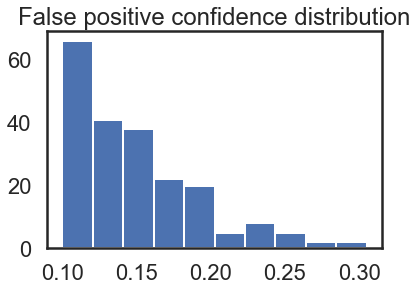

In [12]:
hard_negative = df.loc[~df.index.isin(overlaps.index)]
hard_negative["confidence"].hist(grid=False)
plt.title("False positive confidence distribution");
plt.savefig("fp_conf_dist.svg", format="svg")

In [13]:
df["detect_status"] = ""
df["detect_status"].loc[~df.index.isin(overlaps.index)] = "Hard Negative"
df["detect_status"].loc[overlaps.index] = "Hard Positives"

/home/biel/miniconda3/envs/tfm/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


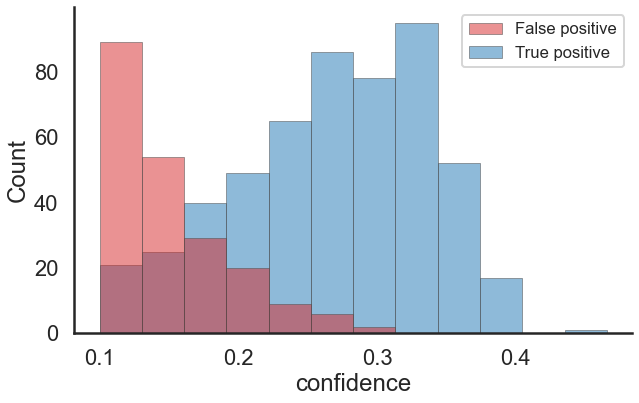

In [14]:
f, ax = plt.subplots(figsize=(10, 6))
sns.despine(f)
g = sns.histplot(
    df,
    x="confidence", hue="detect_status",
#     multiple="stack",
    palette=["tab:red", "tab:blue"],
    edgecolor=".3",
    linewidth=.5,
    ax=ax,
)
legend = ax.get_legend()
handles = legend.legendHandles
ax.legend(handles, ["False positive", "True positive"], title="", fontsize="x-small")
plt.savefig("conf_dist.svg", dpi=90, bbox_inches="tight", format="svg")

In [15]:
hard_positive.to_file("../results/hard_posotive.geojson", driver='GeoJSON')
hard_negative.to_file("../results/hard_negative.geojson", driver='GeoJSON')

In [16]:
truth.shape[0]

589

In [17]:
not_in = gpd.sjoin(truth, df)
misses = truth.loc[~truth.index.isin(not_in.index)]

In [18]:
misses.to_file("../results/misses.geojson", driver='GeoJSON')

In [40]:
len(misses)

57

## ROC curve

1. add col for true positive and false positive 

In [19]:
df["true_positive"] = np.where(df.index.isin(overlaps.index), True, False)
df["false_positive"] = np.where(~df.index.isin(overlaps.index), True, False)

In [20]:
from sklearn import metrics
import matplotlib.pyplot as plt

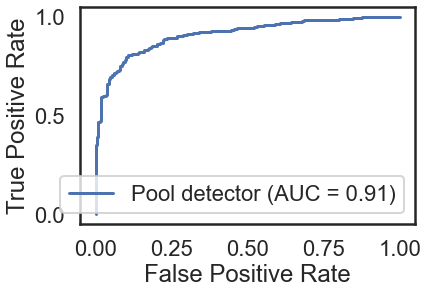

In [21]:
fpr, tpr, thresholds = metrics.roc_curve(df.true_positive, df.confidence)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Pool detector')

display.plot()
plt.show()      

In [22]:
thresholds[1]

0.4655885100364685

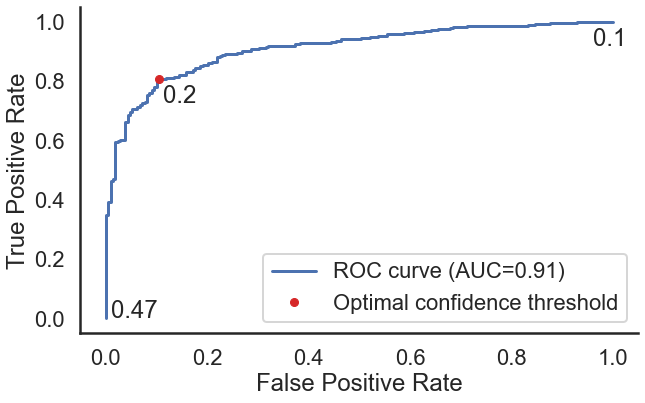

In [23]:
f, ax = plt.subplots(figsize=(10, 6))
sns.despine(f)
ax.plot(fpr, tpr, '-', label="ROC curve (AUC={})".format(round(roc_auc,2)))

ax.annotate(np.round(thresholds[1],2), (fpr[1]+0.01, tpr[1]))
ax.annotate(np.round(thresholds[-1],2), (fpr[-1]-0.04, tpr[-1]-0.08))

threshold_of_interest_idx = np.argmax(tpr - fpr)
threshold_of_interest = round(thresholds[threshold_of_interest_idx], 2)

ax.plot(
    fpr[threshold_of_interest_idx],
    tpr[threshold_of_interest_idx],
    "o",
    c="tab:red",
    markersize=8,
    label=f"Optimal confidence threshold"
)

ax.annotate(
    threshold_of_interest,
    (fpr[threshold_of_interest_idx]+0.007, tpr[threshold_of_interest_idx]-0.08)
)

ax.legend(loc="lower right")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")

plt.savefig("roc_curve.svg", dpi=90, bbox_inches="tight", format="svg")

In [24]:
sum(df.true_positive)

529

In [25]:
truth.shape[0]

589

In [26]:
sum(df.false_positive)

209

## Precision and recall with 0.1 confidence

In [28]:
precission = sum(df.true_positive) / (len(df))
print("precission: ", precission)

precission:  0.7168021680216802


In [ ]:
recall_score()

In [30]:
recall = sum(df.true_positive) / (sum(df.true_positive) + len(misses))
print("recall: ", recall)

recall:  0.9027303754266212


## Precision and recall with 0.2 confidence

In [32]:
df_conf2 = df.loc[df.confidence >= 0.2]

In [33]:
df_conf2

,polyID,confidence,geometry,detect_status,true_positive,false_positive
3,3,0.334212,"POLYGON ((505096.351 4349217.633, 505096.351 4...",Hard Positives,True,False
8,8,0.288953,"POLYGON ((506522.212 4350329.511, 506522.212 4...",Hard Positives,True,False
9,9,0.204643,"POLYGON ((506581.518 4350385.065, 506581.518 4...",Hard Negative,False,True
11,11,0.253999,"POLYGON ((506413.479 4350833.155, 506413.479 4...",Hard Positives,True,False
12,12,0.314654,"POLYGON ((505616.948 4350927.309, 505616.948 4...",Hard Positives,True,False
...,...,...,...,...,...,...
730,730,0.238211,"POLYGON ((503677.402 4353757.583, 503677.402 4...",Hard Positives,True,False
732,732,0.303656,"POLYGON ((508361.406 4353756.988, 508361.406 4...",Hard Positives,True,False
733,733,0.264853,"POLYGON ((512533.137 4353341.981, 512533.137 4...",Hard Positives,True,False
734,734,0.246031,"POLYGON ((504370.950 4353352.838, 504370.950 4...",Hard Positives,True,False


In [42]:
sum(df_conf2.false_positive)

27

In [34]:
not_in_2 = gpd.sjoin(truth, df_conf2)
misses_2 = truth.loc[~truth.index.isin(not_in_2.index)]

In [36]:
len(misses_2)

153

In [37]:
precission2 = sum(df_conf2.true_positive) / (len(df_conf2))
print("precission: ", precission2)

precission:  0.9407894736842105


In [38]:
recall = sum(df_conf2.true_positive) / (sum(df_conf2.true_positive) + len(misses_2))
print("recall: ", recall)

recall:  0.7371134020618557
